## Census Income Dataset

## Problem Statement :
The dataset given below contains the census information about the attributes of individuals as the features and their income as the target. The task is to predict whether a person makes over $50K a year or not.

## About the dataset:
This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics).  

The data has 1032 instances and 15 features. For your information the target variable `Income` has already been label encoded.
1 indicates the income is greater than or equal to 50K. 0 indicates the income is less than 50K. Below is a brief about the features in the dataset.

|Features|Description|
|-----|-----|
|age|Age of the person|
|Workclass|Categorical variable having 8 categories each denoting the type of employment|
|fnlwgt|final weight. |
|education|Categorical variable with 16 categories each denoting the qualification of the person.|
|education-num|number of years of education|
|marital-status|Categorical variable with 7 categories|
|occupation|Categorical variable with 14 categories each denoting the type of occupation of the individual|
|relationship|Categorical variable with 6 categories.|
|race|Categorical variable with 5 categories each denoting the ethnicity of the individual|
|sex|Gender of the person|
|capital-gain|Continuous| 
|capital-loss|Continuous|
|hours-per-week|Working hours per week|
|native-country|Categorical|
|Income|Target variable. 1 indicates >=50k. 0 indicates <50K|



### Reading the data using pandas module.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,f1_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataframe = pd.read_csv('adult_preprocessed.csv',index_col=0)

In [3]:
dataframe.head()

,age,Workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


### Check for null values and get a summary of all the columns in the dataset

In [4]:
# Check for null values
dataframe.isnull().sum()

age               0
Workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
Income            0
dtype: int64

In [5]:
# Get a summary of the columns in the dataset
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1032 entries, 0 to 1119
Data columns (total 15 columns):
age               1032 non-null int64
Workclass         1032 non-null object
fnlwgt            1032 non-null int64
education         1032 non-null object
education-num     1032 non-null int64
marital-status    1032 non-null object
occupation        1032 non-null object
relationship      1032 non-null object
race              1032 non-null object
sex               1032 non-null object
capital-gain      1032 non-null int64
capital-loss      1032 non-null int64
hours-per-week    1032 non-null int64
native-country    1032 non-null object
Income            1032 non-null int64
dtypes: int64(7), object(8)
memory usage: 129.0+ KB


### For further analysis split to bring all the continuous variables together and categorical variables together.

In [6]:
# Seperate continuous variables and categorical variables
cols_con = dataframe.select_dtypes(include='int64')
cols_non_con = dataframe[list(set(dataframe.columns)-set(cols_con))]

###  Plotting a stacked bar chart, have an estimate of the number of people with income above and below 50K with respect to each of the categorical features

In [7]:
list_non_con = ['education', 'Workclass', 'race', 'native-country', 'occupation',
       'relationship', 'marital-status', 'sex']

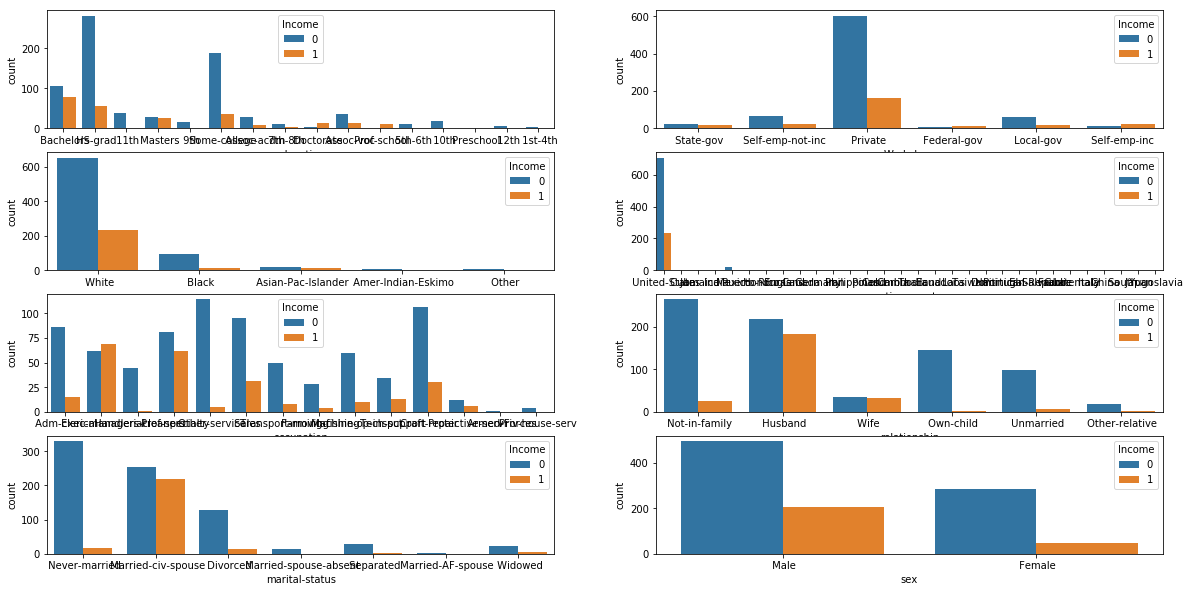

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
#plt.figure()
fig, axes = plt.subplots(4,2,figsize = (20,10))
for i in range(4): 
    for j in range(2):
        col = list_non_con[i*2+j]
        sns.countplot(x = cols_non_con[col],hue= dataframe['Income'],ax=axes[i,j])
        #plt.tick_params(axis='x', rotation=90)
        

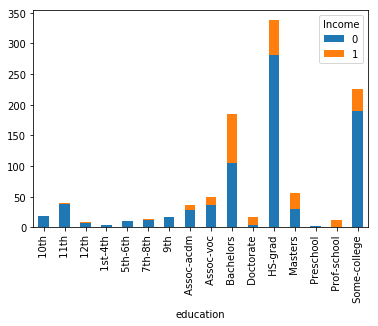

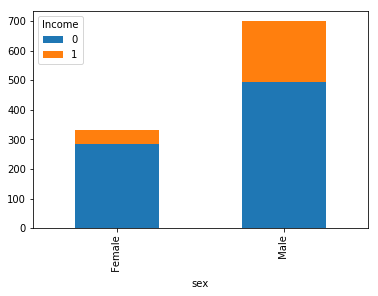

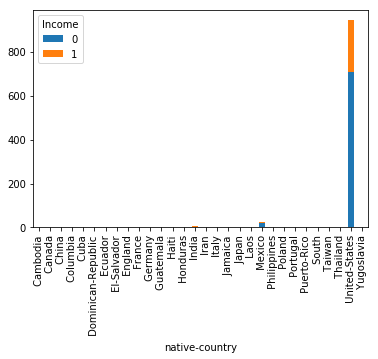

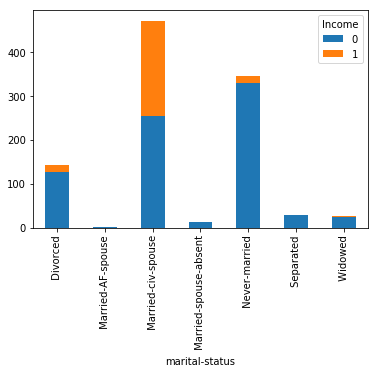

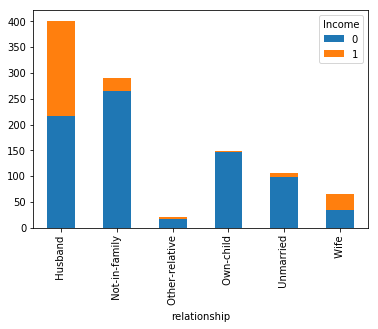

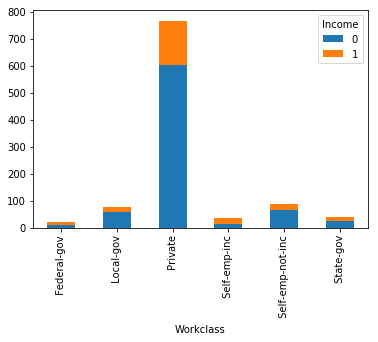

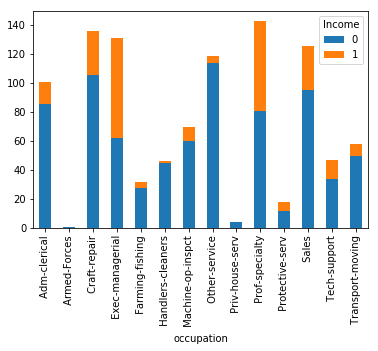

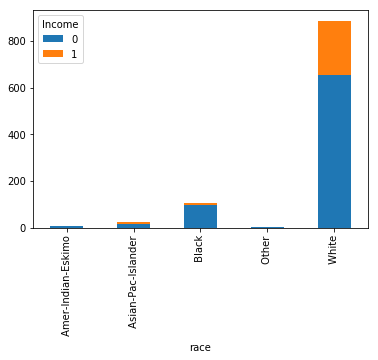

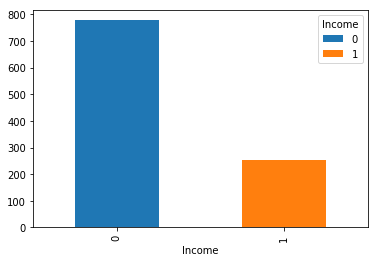

In [10]:
cols_non_con['Income'] = cols_con['Income']
for i in cols_non_con:
    cols_non_con.groupby(i)['Income'].value_counts().unstack().plot.bar(stacked = True, figsize=(6,4))#.reset_index()

### Plot a histogram for all the continuous variables to check for skewness

In [11]:
len(cols_con.columns)

7

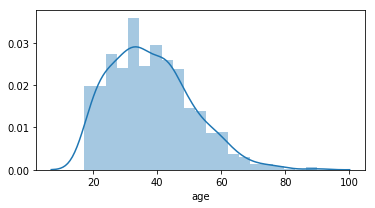

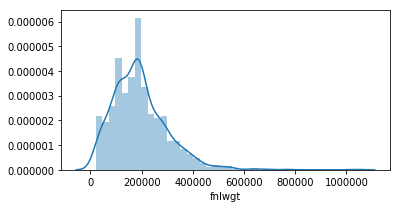

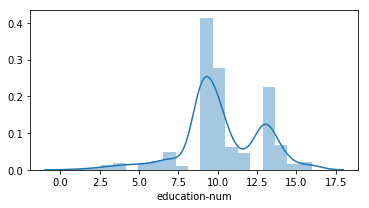

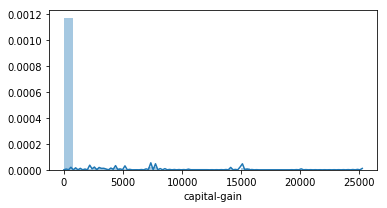

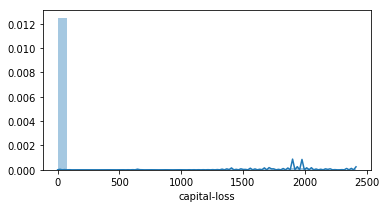

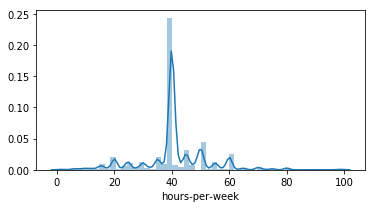

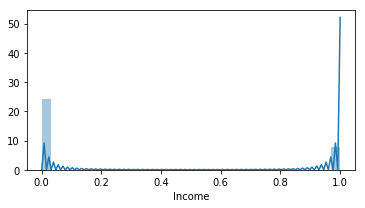

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
n = 1
for i in cols_con.columns:
    plt.figure(figsize=(20,10))
    plt.subplot(3,3,n)
    sns.distplot(cols_con[i])
    n +=1
    

### Majority of values in capital-gain and capital-loss are zeros. So remove the columns

In [13]:
cols_con.drop(['capital-gain','capital-loss'],1,inplace=True)

### Check for skewness in the continuous data

In [14]:
skewness = skew(cols_con)
nn = 0
for col in cols_con:
    print('Skewness of',cols_con.columns[nn],'=',skewness[nn])
    nn +=1


Skewness of age = 0.6160534414051011
Skewness of fnlwgt = 1.3937557919747414
Skewness of education-num = -0.30220179407263537
Skewness of hours-per-week = 0.16318627165535804
Skewness of Income = 1.178757937442853


### The column `fnlwgt` is a highly right skewed column. Remove the skewness using a log transform and then check if the skewness has been removed by plotting its histogram

In [15]:
cols_con['fnlwgt'] = np.sqrt(cols_con['fnlwgt'])

In [16]:
skewness = skew(cols_con)
nn = 0
for col in cols_con:
    print('Skewness of',cols_con.columns[nn],'=',skewness[nn])
    nn +=1


Skewness of age = 0.6160534414051011
Skewness of fnlwgt = 0.21998857739082905
Skewness of education-num = -0.30220179407263537
Skewness of hours-per-week = 0.16318627165535804
Skewness of Income = 1.178757937442853


### Check for the pearson correlation between the continuous variables by plotting a heatmap

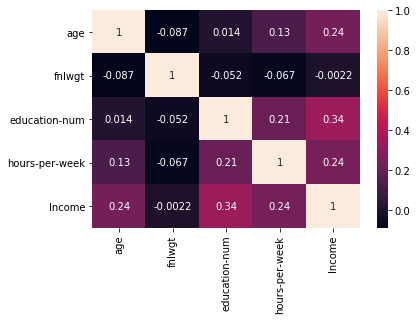

In [17]:
# Check for correlation between continuous variables
sns.heatmap(cols_con.corr(),annot=True)

### Label Encode all the categorical variables

In [18]:
# Label Encode Categorical variables

cols_non_con.drop('Income',1,inplace=True)

In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for j in cols_non_con.columns:
    cols_non_con[j] = label_encoder.fit_transform(cols_non_con[j])

In [20]:
cols_non_con.head()

,education,sex,native-country,marital-status,relationship,Workclass,occupation,race
0,9,1,28,4,1,5,0,4
1,9,1,28,2,0,4,3,4
2,11,1,28,0,1,2,5,4
3,1,1,28,2,0,2,5,2
4,9,0,4,2,5,2,9,2


### Concatenate both the continuous and categorical dataframes

In [21]:
cols_con.head()

,age,fnlwgt,education-num,hours-per-week,Income
0,39,278.416954,13,40,0
1,50,288.636450,13,13,0
2,38,464.377002,9,40,0
3,53,484.480134,7,40,0
4,28,581.729318,13,40,0


In [22]:
df_new = pd.concat([cols_non_con,cols_con],axis=1)

In [23]:
df_new.head()

,education,sex,native-country,marital-status,relationship,Workclass,occupation,race,age,fnlwgt,education-num,hours-per-week,Income
0,9,1,28,4,1,5,0,4,39,278.416954,13,40,0
1,9,1,28,2,0,4,3,4,50,288.636450,13,13,0
2,11,1,28,0,1,2,5,4,38,464.377002,9,40,0
3,1,1,28,2,0,2,5,2,53,484.480134,7,40,0
4,9,0,4,2,5,2,9,2,28,581.729318,13,40,0


### Split into features and target

In [24]:
X = df_new.iloc[:, :-1]
y = df_new.iloc[:, -1]

In [25]:
df_new

,education,sex,native-country,marital-status,relationship,Workclass,occupation,race,age,fnlwgt,education-num,hours-per-week,Income
0,9,1,28,4,1,5,0,4,39,278.416954,13,40,0
1,9,1,28,2,0,4,3,4,50,288.636450,13,13,0
2,11,1,28,0,1,2,5,4,38,464.377002,9,40,0
3,1,1,28,2,0,2,5,2,53,484.480134,7,40,0
4,9,0,4,2,5,2,9,2,28,581.729318,13,40,0
5,12,0,28,2,5,2,3,4,37,533.462276,14,40,0
6,6,0,17,3,1,2,7,2,49,400.233682,5,16,0
7,11,1,28,2,0,4,3,4,52,457.866793,9,45,1
8,12,0,28,4,1,2,9,4,31,213.964950,14,50,1
9,9,1,28,2,0,2,3,4,42,399.310656,13,40,1


### Fit a StandardScaler on the features

In [26]:
# Fitting a Standard Scaler 
scaler = StandardScaler()
for feature in X.columns:
        X[feature] = scaler.fit_transform(X[[feature]])


In [27]:
X.head()

,education,sex,native-country,marital-status,relationship,Workclass,occupation,race,age,fnlwgt,education-num,hours-per-week
0,-0.379789,0.687155,0.260938,0.935132,-0.294678,3.026993,-1.570166,0.390011,0.081561,-1.181232,1.111052,-0.060217
1,-0.379789,0.687155,0.260938,-0.402437,-0.902893,1.941567,-0.819975,0.390011,0.939653,-1.096580,1.111052,-2.361827
2,0.167999,0.687155,0.260938,-1.740006,-0.294678,-0.229286,-0.319849,0.390011,0.003553,0.359145,-0.488677,-0.060217
3,-2.570939,0.687155,0.260938,-0.402437,-0.902893,-0.229286,-0.319849,-2.079263,1.173678,0.525667,-1.288541,-0.060217
4,-0.379789,-1.455275,-5.619778,-0.402437,2.138182,-0.229286,0.680405,-2.079263,-0.776531,1.331218,1.111052,-0.060217


### Split into train and validation data

In [28]:
#from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

### Fit a logistic regression model

In [29]:
y_train.shape

(722,)

In [30]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Checking the accuracy, f1_score, confusion matrix

In [31]:
from sklearn.metrics import precision_score,recall_score, roc_auc_score
print('Accuracy Score is',accuracy_score(y_test,y_pred))
print('f1_score is',f1_score(y_test,y_pred))
print('A precision_score is',precision_score(y_test,y_pred))
print('A recall_score is',recall_score(y_test,y_pred))
print('A roc_auc_score is',roc_auc_score(y_test,y_pred))

Accuracy Score is 0.8225806451612904
f1_score is 0.4954128440366973
A precision_score is 0.6923076923076923
A recall_score is 0.38571428571428573
A roc_auc_score is 0.6678571428571428


In [32]:
confusion_matrix(y_test,y_pred)#.ravel()

array([[228,  12],
       [ 43,  27]], dtype=int64)

In [33]:
tn,fp,fn,tp = confusion_matrix(y_test,y_pred).ravel()

In [34]:
print(tp,fp)
print(fn,tn)

27 12
43 228


### Perform hyperparameter tuning using GridSearch

In [39]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
params = {'penalty':['l1','l2'],'C':[0.001,0.01,0.1,1,10,100]}
grid_search = GridSearchCV(estimator = model,param_grid=params,scoring='f1',cv=10)
grid_search.fit(X_train,y_train)
y_pred_grid = grid_search.predict(X_test)

### Find the best parameters and the metrics after grid search

In [40]:
print('Accuracy Score is',accuracy_score(y_test,y_pred_grid))
print('f1_score is',f1_score(y_test,y_pred_grid))
print('A precision_score is',precision_score(y_test,y_pred_grid))
print('A recall_score is',recall_score(y_test,y_pred_grid))
print('A roc_auc_score is',roc_auc_score(y_test,y_pred_grid))

Accuracy Score is 0.8032258064516129
f1_score is 0.5271317829457364
A precision_score is 0.576271186440678
A recall_score is 0.4857142857142857
A roc_auc_score is 0.6907738095238096


In [37]:
grid_search.best_estimator_

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)